Saving CRWV_2025-05-02 00_00_00+00_00.csv to CRWV_2025-05-02 00_00_00+00_00.csv
Saving FROG_2025-05-02 00_00_00+00_00.csv to FROG_2025-05-02 00_00_00+00_00.csv
Saving SOUN_2025-05-02 00_00_00+00_00.csv to SOUN_2025-05-02 00_00_00+00_00.csv


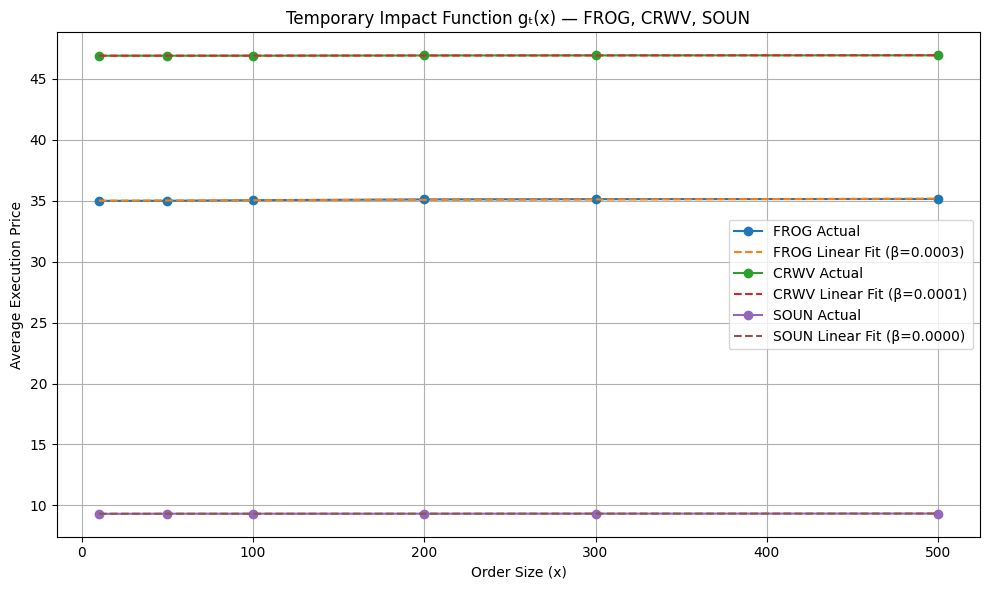

In [3]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 🔄 Upload Your 3 CSV Files First
from google.colab import files
uploaded = files.upload()

# 📁 Load all 3 datasets
frog = pd.read_csv([f for f in uploaded if 'FROG' in f][0])
crwv = pd.read_csv([f for f in uploaded if 'CRWV' in f][0])
soun = pd.read_csv([f for f in uploaded if 'SOUN' in f][0])

# 📆 Convert timestamps
frog['ts_event'] = pd.to_datetime(frog['ts_event'])
crwv['ts_event'] = pd.to_datetime(crwv['ts_event'])
soun['ts_event'] = pd.to_datetime(soun['ts_event'])

# 📚 Common bid/ask columns
bid_prices = [f"bid_px_0{i}" for i in range(10)]
ask_prices = [f"ask_px_0{i}" for i in range(10)]
bid_sizes = [f"bid_sz_0{i}" for i in range(10)]
ask_sizes = [f"ask_sz_0{i}" for i in range(10)]

# 🧠 g_t(x) calculation
def compute_impact(row, x):
    total_shares = 0
    total_cost = 0
    for i in range(10):
        px = row.get(f'ask_px_0{i}')
        sz = row.get(f'ask_sz_0{i}')
        if pd.isna(px) or pd.isna(sz): continue
        take = min(sz, x - total_shares)
        total_cost += take * px
        total_shares += take
        if total_shares >= x:
            break
    if total_shares < x: return None
    return total_cost / x

# 🔧 Function to generate impact data
def generate_impact_data(df, row_idx=100, x_values=[10, 50, 100, 200, 300, 500]):
    row = df.iloc[row_idx]
    g_vals = [compute_impact(row, x) for x in x_values]
    valid = [(x, g) for x, g in zip(x_values, g_vals) if g is not None]
    if not valid: return None, None, None, None
    x_fit = np.array([v[0] for v in valid]).reshape(-1, 1)
    y_fit = np.array([v[1] for v in valid])
    model = LinearRegression().fit(x_fit, y_fit)
    y_pred = model.predict(x_fit)
    return x_fit.flatten(), y_fit, y_pred, model.coef_[0]

# 🎯 Generate for each stock
frog_x, frog_y, frog_pred, frog_beta = generate_impact_data(frog)
crwv_x, crwv_y, crwv_pred, crwv_beta = generate_impact_data(crwv)
soun_x, soun_y, soun_pred, soun_beta = generate_impact_data(soun)

# 📊 Plot Comparison
plt.figure(figsize=(10, 6))
if frog_x is not None:
    plt.plot(frog_x, frog_y, 'o-', label=f"FROG Actual")
    plt.plot(frog_x, frog_pred, '--', label=f"FROG Linear Fit (β={frog_beta:.4f})")
if crwv_x is not None:
    plt.plot(crwv_x, crwv_y, 'o-', label=f"CRWV Actual")
    plt.plot(crwv_x, crwv_pred, '--', label=f"CRWV Linear Fit (β={crwv_beta:.4f})")
if soun_x is not None:
    plt.plot(soun_x, soun_y, 'o-', label=f"SOUN Actual")
    plt.plot(soun_x, soun_pred, '--', label=f"SOUN Linear Fit (β={soun_beta:.4f})")

plt.title("Temporary Impact Function gₜ(x) — FROG, CRWV, SOUN")
plt.xlabel("Order Size (x)")
plt.ylabel("Average Execution Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# 🎯 Total shares to buy
S = 10000
T = 390  # minutes in a trading day
unit_size = 50
max_per_minute = 500

# 🔁 Limit dataset to first 390 rows (1 per minute snapshot)
frog_390 = frog.head(T).copy()

# 🧠 Helper: Compute gₜ(x)
def compute_impact(row, x):
    total_shares = 0
    total_cost = 0
    for i in range(10):
        px = row.get(f'ask_px_0{i}')
        sz = row.get(f'ask_sz_0{i}')
        if pd.isna(px) or pd.isna(sz): continue
        take = min(sz, x - total_shares)
        total_cost += take * px
        total_shares += take
        if total_shares >= x: break
    if total_shares < x: return None
    return total_cost / x

# 🟩 Uniform Allocation
uniform_x = S // T
uniform_cost = 0
for i in range(T):
    row = frog_390.iloc[i]
    g = compute_impact(row, uniform_x)
    if g:
        uniform_cost += g * uniform_x

print(f"🟢 Uniform Total Cost: ${uniform_cost:.2f}")

# 🟨 Greedy Allocation: Prioritize low-impact minutes
def estimate_unit_impact(df, unit_size=50):
    impacts = []
    for i, row in df.iterrows():
        g = compute_impact(row, unit_size)
        impacts.append((i, g if g else float('inf')))
    return sorted(impacts, key=lambda x: x[1])

greedy_cost = 0
remaining = S
allocation = {}
impacts = estimate_unit_impact(frog_390)

for i, g in impacts:
    row = frog_390.iloc[i]
    alloc = min(remaining, max_per_minute)
    price = compute_impact(row, alloc)
    if price:
        greedy_cost += price * alloc
        allocation[i] = alloc
        remaining -= alloc
    if remaining <= 0: break

print(f"🟡 Greedy Total Cost: ${greedy_cost:.2f}")
print(f"Greedy used {len(allocation)} minutes out of 390")

🟢 Uniform Total Cost: $341947.50
🟡 Greedy Total Cost: $352137.71
Greedy used 20 minutes out of 390
